# Image classification
**Profect description:** Car model classification by image.
# Work plan
1. Pick Xception NN learned on ImageNet dataset (transfer learning).
2. Create baseline: learn new head (top dense layer) of chosen NN model, predict and submit.
3. Data augmentation.
4. Configure learning rate scheduler.
5. Try another NN model.
6. Hyperparameters tuning.
7. Fine tuning.
8. TTA.

In [1]:
# Show GPU card characteristics
!nvidia-smi

Wed Feb  3 08:52:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install additional libraries
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-de4f2ghx
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-de4f2ghx
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=7f779bd8d889e20d9f3ed4c01c6d30aa51871d309769440e91b81d7d2c1dd9e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-3slf4tb6/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import collections
import math
import os
import shutil
import sys
from pathlib import Path

import albumentations as A
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from ImageDataAugmentor.image_data_augmentor import ImageDataAugmentor
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras import Sequential
from tensorflow.keras.applications import Xception, EfficientNetB6
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2


print('Python:'.ljust(16), sys.version.split('\n')[0])
print('Numpy:'.ljust(16), np.__version__)
print('Pandas:'.ljust(16), pd.__version__)
print('TensorFlow:'.ljust(16), tf.__version__)
print('Keras:'.ljust(16), tf.keras.__version__)

Python:          3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpy:           1.19.5
Pandas:          1.1.5
TensorFlow:      2.4.0
Keras:           2.4.0


In [4]:
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/src/script.ipynb
/kaggle/lib/kaggle/gcp.py
/kaggle/input/sf-dl-car-classification/train.zip
/kaggle/input/sf-dl-car-classification/sample-submission.csv
/kaggle/input/sf-dl-car-classification/test.zip
/kaggle/input/sf-dl-car-classification/train.csv
/kaggle/input/image-classification-public/best_model.hdf5
/kaggle/input/image-classification-public/__results__.html
/kaggle/input/image-classification-public/submission.csv
/kaggle/input/image-classification-public/requirements.txt
/kaggle/input/image-classification-public/__notebook__.ipynb
/kaggle/input/image-classification-public/__output__.json
/kaggle/input/image-classification-public/model.hdf5
/kaggle/input/image-classification-public/custom.css
/kaggle/input/image-classification-public/__results___files/__results___31_1.png
/kaggle/input/image-classification-public/__results___files/__results___23_1.png
/kaggle/input/image-classification-public/__results___files/__results___63_1.png
/kaggle/input/image-classification-public

In [5]:
# Save requirements
!pip freeze > requirements.txt

In [6]:
# G L O B A L   C O N S T A N T S
RANDOM_SEED          = 42    # Random seed
np.random.seed(RANDOM_SEED)  

EPOCHS               = 30    # Epochs to learn
BATCH_SIZE           = 16    # Batch size to learn
VALIDATION_SPLIT     = 0.15  # Fraction of images reserved for validation (strictly between 0 and 1)
LR_FACTOR            = 0.95  # Factor for decreasing learning rate every training epoch

CLASS_NUM            = 10    # Number of classes
IMG_SIZE             = 256   # Image size for network input
IMG_CHANNELS         = 3     # Image channels (3 channels in RGB)
INPUT_SHAPE          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sf-dl-car-classification/' # Input data directory
WORKING_PATH = '../working/temp/' # Working directory

# EDA

**Unzip files**

In [7]:
# Unzip files to working directory to see them
shutil.unpack_archive(DATA_PATH + 'train.zip', WORKING_PATH, 'zip')
shutil.unpack_archive(DATA_PATH + 'test.zip', WORKING_PATH + 'test/', 'zip')

print('Number of train paths:', len(os.listdir(WORKING_PATH + 'train/')))
print('Number of test paths:', len(os.listdir(WORKING_PATH + 'test/test_upload/')))

Number of train paths: 10
Number of test paths: 6675


**Read train and test datasets**

In [8]:
train_df = pd.read_csv('/kaggle/input/sf-dl-car-classification/train.csv')
sample_submission = pd.read_csv('/kaggle/input/sf-dl-car-classification/sample-submission.csv')

**Show general information of datasets**

In [9]:
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [10]:
sample_submission.head()

,Id,Category
0,305108.jpg,0
1,295075.jpg,0
2,31197.jpg,0
3,93598.jpg,0
4,87877.jpg,0


In [11]:
train_df.info()
print()
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6675 entries, 0 to 6674
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        6675 non-null   object
 1   Category  6675 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 104.4+ KB


**View unique values**

In [12]:
train_df['Category'].value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

The distribution of classes is fairly uniform - that's good. Let's look at examples of pictures and their sizes in order to understand how to better process and compress them.

**View image formats for train and test datasets**

In [13]:
# Compute freq count for train formats
c_train_format = collections.Counter()
c_train_mode = collections.Counter()
c_train_size = collections.Counter()
c_train_info = collections.Counter()
for index in tqdm(train_df.index):
    img = PIL.Image.open(WORKING_PATH + 'train/'
                         + str(train_df.loc[index, 'Category'])
                         + '/' + train_df.loc[index, 'Id'])
    c_train_format[img.format] += 1
    c_train_mode[img.mode] += 1
    c_train_size[img.size] += 1
    c_train_info[str(img.info)] += 1

# Compute freq count for test formats
c_test_format = collections.Counter()
c_test_mode = collections.Counter()
c_test_size = collections.Counter()
c_test_info = collections.Counter()
for img in tqdm(sample_submission['Id']):
    img = PIL.Image.open(WORKING_PATH + 'test/test_upload/' + img)
    c_test_format[img.format] += 1
    c_test_mode[img.mode] += 1
    c_test_size[img.size] += 1
    c_test_info[str(img.info)] += 1
    
# Show result
print('Train:', c_train_format)
print('Test: ', c_test_format)
print()
print('Train:', c_train_mode)
print('Test: ', c_test_mode)

100%|██████████| 6675/6675 [00:00<00:00, 8357.79it/s]

Train: Counter({'JPEG': 15561})
Test:  Counter({'JPEG': 6675})

Train: Counter({'RGB': 15556, 'L': 5})
Test:  Counter({'RGB': 6673, 'L': 2})


**View image examples**

Image examples (random sample)


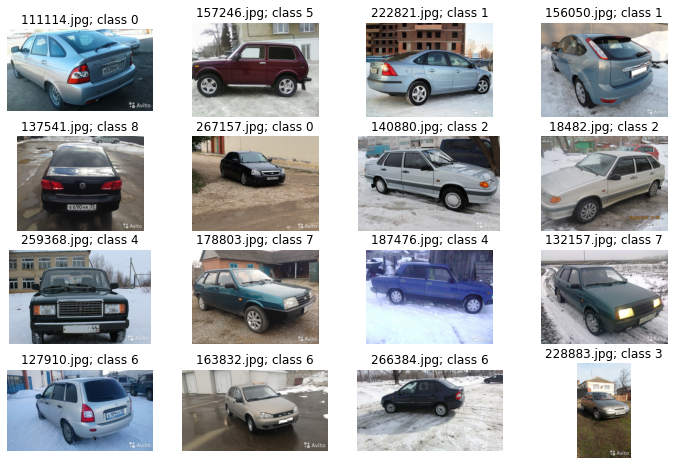

In [14]:
# Show image examples from random sample
samples_number = 16
print('Image examples (random sample)')
plt.figure(figsize=(12, 8))
random_image = train_df.sample(n=samples_number)
random_image_id = random_image['Id'].values
random_image_cat = random_image['Category'].values
for index, image_id in enumerate(random_image_id):
    img = PIL.Image.open(WORKING_PATH + f'train/{random_image_cat[index]}/{image_id}')
    subplot_len = math.ceil(math.sqrt(samples_number))
    plt.subplot(subplot_len, subplot_len, index + 1)
    plt.imshow(img)
    plt.title(str(image_id) + '; class ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

JPEG
RGB
(640, 480)
{'jfif': 257, 'jfif_version': (1, 1), 'dpi': (1, 1), 'jfif_unit': 1, 'jfif_density': (1, 1)}


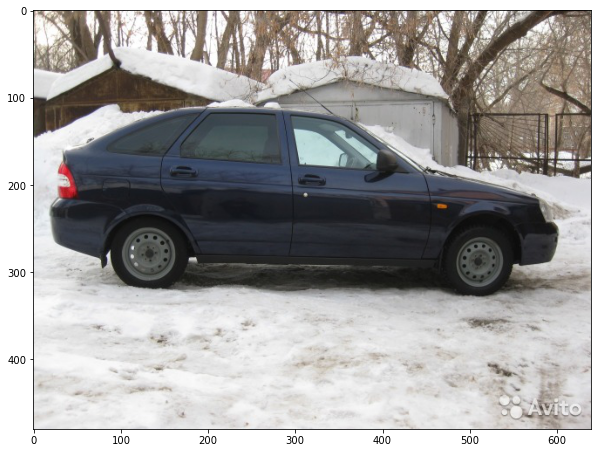

In [15]:
# Show one image example and it's format
img = PIL.Image.open(WORKING_PATH + '/train/0/100380.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(img)
print(img.format)
print(img.mode)
print(img.size)
print(img.info)

# Data preparing
## Stratified splitting

In [16]:
# Split on train and validation parts
train_files, validation_files = train_test_split(
    train_df, test_size=VALIDATION_SPLIT,
    random_state=RANDOM_SEED, stratify=train_df['Category'],
)

# Change 'Category' column type to 'string' (necessary for datagenerator)
train_files = train_files.astype({'Category': 'string'})
validation_files = validation_files.astype({'Category': 'string'})

# View dataset shapes
train_files.shape, validation_files.shape

((13226, 2), (2335, 2))

In [17]:
train_files['Category'].value_counts()

1    1675
8    1500
6    1473
5    1386
0    1371
3    1299
2    1239
4    1190
9    1067
7    1026
Name: Category, dtype: Int64

In [18]:
validation_files['Category'].value_counts()

1    296
8    265
6    260
5    245
0    242
3    229
2    219
4    210
9    188
7    181
Name: Category, dtype: Int64

## Data augmentation
**Configure generators**

In [19]:
# Configure augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.ShiftScaleRotate(shift_limit=0.0, scale_limit=0.20,
                           rotate_limit=25, p=0.5),
        A.OpticalDistortion(distort_limit=0.3, shift_limit=0.3,
                            interpolation=1, border_mode=4,
                            value=None, mask_value=None, p=0.5),
    ], p=1),
    A.OneOf([
        A.JpegCompression(quality_lower=60, quality_upper=100, p=0.5),
        A.Blur(blur_limit=5, p=0.5),
    ], p=1),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2,
                  hue=0.0, p=1),
])

# Initialize data generators for train and test
train_datagen = ImageDataAugmentor(
    augment=transform,
    preprocess_input=None,
    seed=RANDOM_SEED,
    validation_split=VALIDATION_SPLIT,
)
test_datagen = ImageDataAugmentor(
    augment=None,
    preprocess_input=None,
    seed=RANDOM_SEED,
)

# Wrap training data to generator
train_generator = train_datagen.flow_from_directory(
    directory=WORKING_PATH + 'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training',
)

# Wrap validation data to generator
valid_generator = train_datagen.flow_from_directory(
    directory=WORKING_PATH + 'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation',
)

# Wrap test data to generator
test_generator = test_datagen.flow_from_directory(
    directory=WORKING_PATH + 'test/',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 images belonging to 1 classes.


**View augmented images**

Image augmentation examples


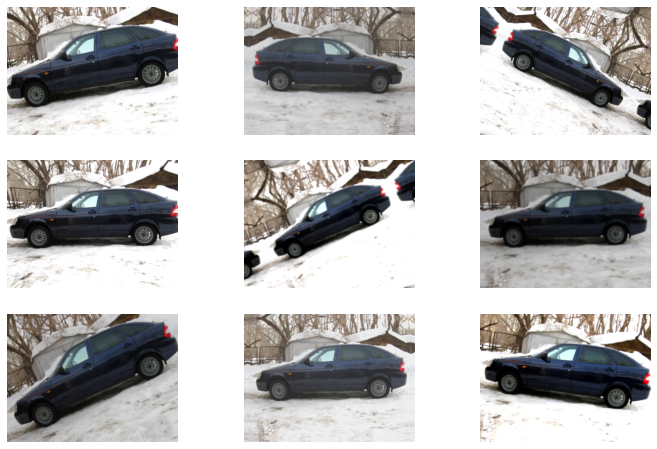

In [20]:
# load the image
img = PIL.Image.open(WORKING_PATH + '/train/0/100380.jpg')
# convert to numpy array
data = np.asarray(img)
# expand dimension to one sample
samples = np.expand_dims(data, 0)
# prepare iterator
it = train_datagen.flow(samples, batch_size=1)

# generate samples and plot
samples_number = 9
print('Image augmentation examples')
plt.figure(figsize=(12, 8))
for index in range(samples_number):
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # define subplot
    subplot_len = math.ceil(math.sqrt(samples_number))
    plt.subplot(subplot_len, subplot_len, index + 1)
    # plot raw pixel data
    plt.imshow(image)
    plt.axis('off')
plt.show()

# Model implementation
## Configure checkpoint list

In [21]:
# Configure checkpoint list
checkpoint_1 = ModelCheckpoint(filepath='model.hdf5',
                               monitor=['val_accuracy'],
                               verbose=1,
                               save_best_only=False,
                               mode='max')
checkpoint_2 = ModelCheckpoint(filepath='best_model.hdf5',
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True,
                               mode='max')
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=3,
                          restore_best_weights=False,)
lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * LR_FACTOR)
callbacks_list = [checkpoint_1, checkpoint_2, earlystop, lr_scheduler]

## Assemble the model

In [22]:
# Clear session
clear_session()

# Load pre-trained EfficientNet as a base model
base_model = EfficientNetB6(include_top=False, input_shape=INPUT_SHAPE)

165240832/165234480 [==============================] - 1s 0us/step


In [23]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(CLASS_NUM, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 8, 8, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                23050     
Total params: 40,983,193
Trainable params: 40,758,754
Non-trainable params: 224,439
_________________________________________________________________


In [24]:
print('Number of layers:', len(model.layers))
print('Number of layers in the base model: ', len(base_model.layers))

Number of layers: 4
Number of layers in the base model:  666


Рекомендация 1. Добавьте другие функции из https://keras.io/callbacks/

Рекомендация 2. Используйте разные техники управления Learning Rate
https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng)
http://teleported.in/posts/cyclic-learning-rate/ (eng)

## Model learning

In [25]:
def plot_history(history):
    """Plot learning process graphs."""
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, accuracy, 'b', label='Training')
    plt.plot(epochs, val_accuracy, 'r', label='Validation')
    plt.title('Accuracy')
    plt.legend()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Loss')
    plt.legend()
    
    
def lr_range_test(steps_num=5, init_lr=1e-4, max_lr=10):
    """Range test for learning rate.
    
    steps_num - number of steps from init_lr to max_lr
    init_lr - initial LR
    max_lr - maximum LR
    """

    # Factor for learning rate increasing
    lr_factor = (max_lr/init_lr)**(1/steps_num)

    # Define learning rate scheduler
    callback = LearningRateScheduler(lambda epoch, lr: lr * lr_factor)

    # Compile the model
    model.compile(optimizer=Adam(lr=init_lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(x=valid_generator,
                        epochs=steps_num + 1,
                        callbacks=[callback],)
    
    
def train_model(LR):
    """Compile, train, plot training process and evaluate."""
    # Compile the model for training
    model.compile(optimizer=Adam(lr=LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # View the model configuration
    model.summary()
    
    # Train the model
    history = model.fit(
        x=train_generator,
        epochs=EPOCHS,
        callbacks=callbacks_list,
        validation_data=valid_generator,
    )
    
    # Plot learning process
    plot_history(history)

    # Load model with the best result
    model.load_weights('best_model.hdf5')

    # Compute score
    scores = model.evaluate(valid_generator)
    print("Validation accuracy: %.2f %%" % (scores[1]*100))

### Evaluating metric before learning

In [26]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Compute score
scores = model.evaluate(valid_generator)
print("Validation accuracy: %.2f %%" % (scores[1]*100))

146/146 [==============================] - 39s 201ms/step - loss: 2.3224 - accuracy: 0.1073
Validation accuracy: 11.16 %


Validation accuracy is about 10 % because now we have 10 classes and random weights of the model head.

### Learning the model with feature tuning

**Load weights and evaluate**

In [28]:
# # Load model with the best result if needed
# model.load_weights('/kaggle/input/image-classification/best_model.hdf5')

# # Compile the model
# model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# # Compute score
# scores = model.evaluate(valid_generator)
# print("Validation accuracy: %.2f %%" % (scores[1]*100))

**Range test for learning rate**

In [29]:
# Range test for learning rate
# lr_range_test(steps_num=6, init_lr=1e-6, max_lr=1e-4)

$$ lr_{i} = init\_lr\cdot\Bigg(\frac{max\_lr}{init\_lr}\Bigg)^{\frac{i}{steps\_num}} $$

$$ i = epoch\_num-1 $$

The minimum loss is detected at the learning rate about $2\cdot10^{-3}$. We should choose maximum learning rate one order lower than the learning rate where loss is minimum. So maximum learning rate equals to $2\cdot10^{-4}$.

**Define trainable layers and train for step 1**

In [30]:
# Define base model parameters as non-trainable
base_model.trainable = False

# Check trainable status of individual layers
for layer in model.layers:
    print(layer, layer.trainable)
    
print()
print('Trainable variables:', len(model.trainable_variables))

<tensorflow.python.keras.engine.functional.Functional object at 0x7f71b1828090> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f713c187890> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f713c18e410> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f713c18ed90> True

Trainable variables: 2


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 8, 8, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                23050     
Total params: 40,983,193
Trainable params: 23,050
Non-trainable params: 40,960,143
_________________________________________________________________
Epoch 1/30
827/827 [==============================] - 215s 240ms/step - loss: 2.0480 - accuracy: 0.2682 - val_loss: 1.5980 - val_accuracy: 0.4775

Epoch 00001: saving model to model.hdf5

Epoch 00001: val_accuracy improved from -inf to 0

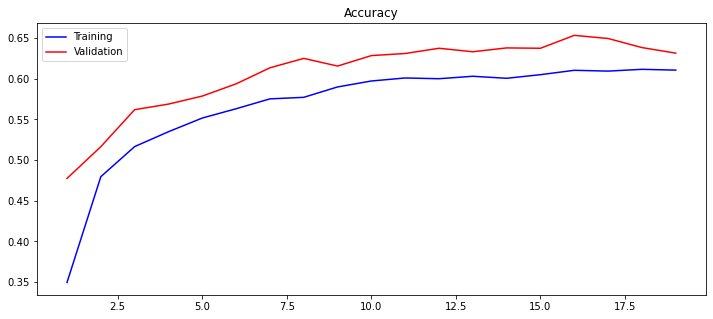

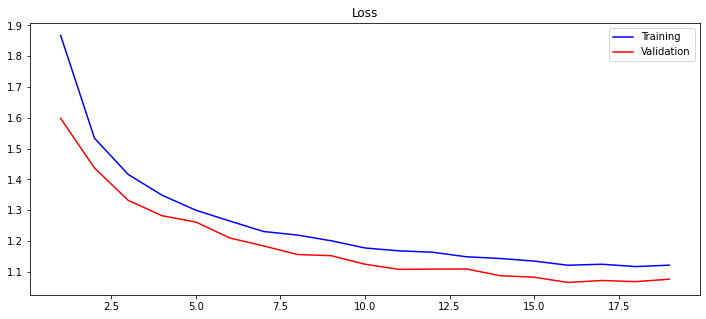

In [31]:
train_model(2e-4)

**Define trainable layers and train for step 2**

In [32]:
# Define base model parameters as trainable
base_model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer number
fine_tune_at = len(base_model.layers) // 2
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Check trainable status of individual layers
for layer in model.layers:
    print(layer, layer.trainable)
    
print()
print('Trainable variables:', len(model.trainable_variables))

<tensorflow.python.keras.engine.functional.Functional object at 0x7f71b1828090> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f713c187890> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f713c18e410> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f713c18ed90> True

Trainable variables: 294


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 8, 8, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                23050     
Total params: 40,983,193
Trainable params: 37,843,936
Non-trainable params: 3,139,257
_________________________________________________________________
Epoch 1/30
827/827 [==============================] - 262s 294ms/step - loss: 1.5989 - accuracy: 0.4283 - val_loss: 0.9472 - val_accuracy: 0.6775

Epoch 00001: saving model to model.hdf5

Epoch 00001: val_accuracy improved from 0.6535

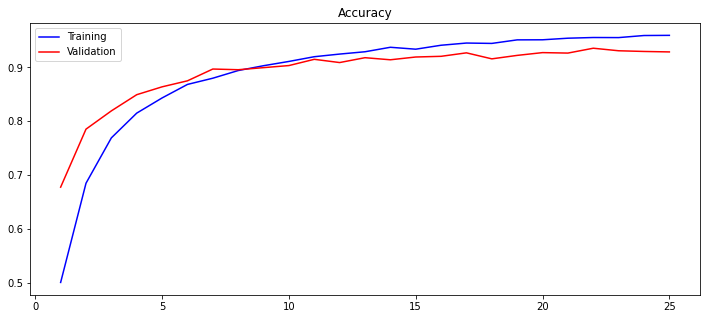

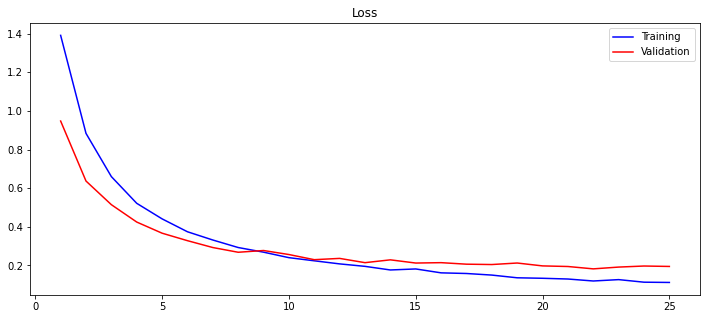

In [33]:
train_model(1e-5)

**Define trainable layers and train for step 3**

In [34]:
# Define base model parameters as trainable
base_model.trainable = True

# Check trainable status of individual layers
for layer in model.layers:
    print(layer, layer.trainable)

print()
print('Trainable variables:', len(model.trainable_variables))

<tensorflow.python.keras.engine.functional.Functional object at 0x7f71b1828090> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f713c187890> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f713c18e410> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f713c18ed90> True

Trainable variables: 584


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 8, 8, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                23050     
Total params: 40,983,193
Trainable params: 40,758,754
Non-trainable params: 224,439
_________________________________________________________________
Epoch 1/30
827/827 [==============================] - 547s 631ms/step - loss: 0.1479 - accuracy: 0.9482 - val_loss: 0.1824 - val_accuracy: 0.9386

Epoch 00001: saving model to model.hdf5

Epoch 00001: val_accuracy improved from 0.93559 

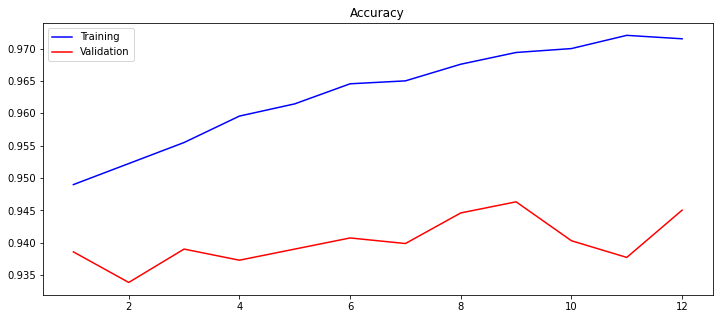

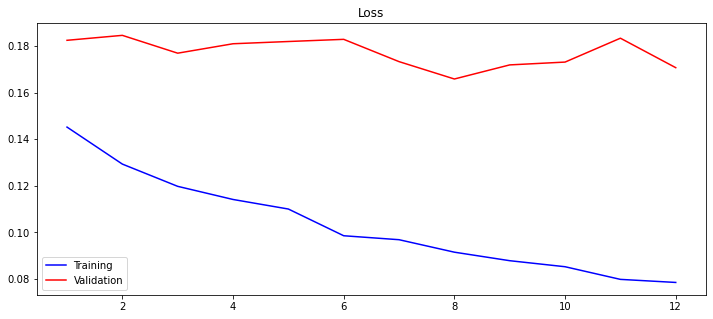

In [35]:
train_model(5e-6)

# Submission
## Predict

In [36]:
# Predict probabilities for all classes
predictions = model.predict(test_generator)
print(predictions.shape)

# Choose indices for classes with maximum probability
predictions = np.argmax(predictions, axis=-1)
print(predictions.shape)

# Swap labels and indices of classes
label_map = train_generator.class_indices
label_map = dict((index, label) for label, index in label_map.items())

# Replace indices with classes
predictions = [label_map[k] for k in predictions]
print(len(predictions))

(6675, 10)
(6675,)
6675


## Save to submission file

In [37]:
# Save to file
submission = pd.DataFrame({'Id': test_generator.filenames, 'Category': predictions})
submission['Id'] = submission['Id'].str.replace('test_upload/', '')
submission.to_csv('submission.csv', index=False)
submission

,Id,Category
0,293307.jpg,3
1,293359.jpg,3
2,293370.jpg,3
3,293435.jpg,3
4,293520.jpg,3
...,...,...
6670,99968.jpg,8
6671,99972.jpg,3
6672,99977.jpg,2
6673,99979.jpg,0


In [38]:
# Clean WORKING_PATH
shutil.rmtree(WORKING_PATH)